## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn

#plt.style.use('dark_background')

# For debugging we will use the below inside some functions.
torch.autograd.set_detect_anomaly(True)
        

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [2]:
# defining standard deviation and strength of stimulus
strength = 0.032
stim_strength = strength * np.hstack((-np.flip(2**np.arange(0,5)), 2**np.arange(0,5)))


In [3]:
# TODO: check the dimensions needed for the target y.


def generate_data(time_length, trials, stim_strength, std = 0.03):
    """
    ksi is a normally distr noise with sigma 0.03.
    u is an input
    û is the stimulis strength
    y is the target, i.e. the sign of û. 
    y's zeroth dimension is trials. 
    """
    ksi = std * np.random.randn(time_length, trials)
    
  
    û_value = np.random.choice(stim_strength, size=trials)
    û = np.full_like(ksi, 0)
    y = np.full_like(trials, 1)
    for i in range(trials):  # vectorize it??
        û[5:46, i] = û_value[i]
        y = np.sign(û_value)
    
    return  torch.from_numpy(û + ksi).reshape([time_length, trials, 1, 1]), torch.from_numpy(y)


In [4]:
# generate data

T = 75
trials = 8
u, y = generate_data(T, trials, stim_strength)
time = np.arange(0,T)


In [5]:
u.shape, y.shape
y[2]

tensor(-1., dtype=torch.float64)

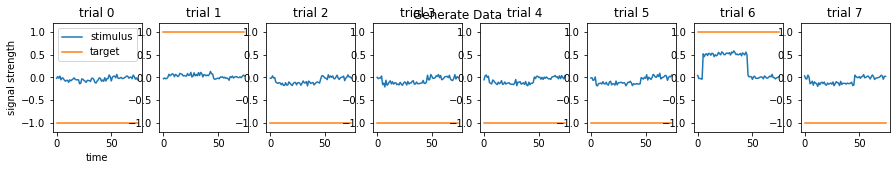

In [6]:
# plot

fig, axs = plt.subplots(1, trials, figsize=(15,2))

fig.suptitle("Generate Data")

for i in range(trials):
    axs[i].plot(time, u[:, i, 0, 0], label="stimulus")
    axs[i].plot(time, y[i]*np.full_like(time,1), label="target")
    axs[i].set_title(f"trial {i}")
    axs[i].set_ylim(-1.2, 1.2)
axs[0].set_xlabel("time")
axs[0].set_ylabel("signal strength")
axs[0].legend()
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

J matrix has to have two trainable vectors m, and n as parameters.

In [7]:
# TODO: vectorize input and targets and all into batch of time and trials.

In [8]:
#Todo: finish refactoring for batch dim, reduce the reshapings.

def dynamics(x, u_of_t, tau, m,n,I):
    J_of_phi_x = torch.div(torch.matmul(torch.matmul(m, n).float(), torch.tanh(x).float()), len(n))

    return (-x + J_of_phi_x + u_of_t*I) / tau  # is broadcasting working for input and in weigths?


In [9]:
# Test dynamics.
x = torch.randn([2,124,1])   # trials, size of the network, and 1 dimension
I = torch.randn([124,1])   # size of the network and 1 dimension

u, y = generate_data(74, 2, stim_strength) # time, trials, stimulis strength
tau = 5


m = torch.randn(2, 124, 1)
n = torch.randn(2, 1, 124)
(u[50]*I).shape, dynamics(x, u[50], tau, m, n, I).shape


(torch.Size([2, 124, 1]), torch.Size([2, 124, 1]))

In [10]:

class LR_RNN(nn.Module):
    # Low-rank recurrent neural network without readout.
    def __init__(self, N):
        super().__init__()
        
        # storign info
        self.N = N
        
        # pattern from witch connectivity is made
        tensor_m = torch.randn([N,1])
        self.m = nn.Parameter(tensor_m)
        
        # pattern to which connectivity is made
        tensor_n = torch.randn([1,N])
        self.n = nn.Parameter(tensor_n)
        
        # input weights
        self.I = torch.randn([N,1])
        
        # Output is defined separetly in different class below.

          
    def forward(self, x, u_of_t, tau, dt):
        # It's an Euler method.
        torch.autograd.set_detect_anomaly(True)
        
        return x +  dt * dynamics(x, u_of_t, tau, self.m, self.n, self.I)
   

In [11]:
ratio = 1500/75 #ms/step
tau_steps = 100 /ratio #ms/(ms/step)
dt = 20 /ratio

print("Ratio is ", ratio, "ms/step, while tau in steps is ", tau_steps, " and time increment in dynamics is ", dt)

Ratio is  20.0 ms/step, while tau in steps is  5.0  and time increment in dynamics is  1.0


In [12]:
class Model(nn.Module):
    def __init__(self, trials, N):
        super().__init__()
        # storing info
        self.N = N
        
        # the layer
        self.lr_rnn = LR_RNN(N)
        
        # output layer
        std_dev = 4
        self.w = std_dev*torch.randn([1, N])
        

    
    def forward(self, x: torch.Tensor, u_of_t, tau, dt):
        
        """
        Going forward with the low rank rnn and input.
        Reading through electrode weights.
        """
        x_next = self.lr_rnn(x, u_of_t, tau, dt)

        torch.autograd.set_detect_anomaly(True)
        
        z = 1/self.N * torch.matmul(self.w.float(), torch.tanh(x_next).float())
        z.squeeze_()
        return x_next, z
        

In [13]:
# TODO: check dimensions for multiplication self.w with tanh(x)

In [14]:
# Initialize.

N = 128
trials = 32    # Mini-batch size, minimum value is 2 (probably because of squeezing and broadcasting).
model = Model(trials, N)
x = torch.zeros([trials,N,1])



In [15]:
ratio = 1500/75 #ms/step
tau = 100 /ratio #ms/(ms/step)
dt = 20 /ratio

print("Ratio is ", ratio, "ms/step, while tau in steps is ", tau, " and time increment in dynamics is ", dt)

Ratio is  20.0 ms/step, while tau in steps is  5.0  and time increment in dynamics is  1.0


In [16]:
# Generate the data.

T = 75
read_onset = 15  # how many last steps are read
time = np.arange(0,T)


In [ ]:
# TODO: train general network (generate data new for each epoch)

In [42]:
"""
Training:

From the readout onset the network is unrolled 

and the backpropagation goes back in time until the beginning of the readout.

Backprop is called after computing the error on the whole batch.


"""

epochs = 10

mse_loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
losses_record = []

for epoch in range(epochs):


        
        x = [None]*(read_onset+1)
        x[0] = torch.zeros([trials, model.N, 1])
        u, y = generate_data(T, trials, stim_strength)
        
        for t in range(T-read_onset):
            
            # Override x zero.
            x[0] = model.lr_rnn.forward(x[0], u[t], tau, dt)
            
        x[0].detach_()
 
        # Option 0
        z = torch.zeros(read_onset, trials)       
        
        for k in range(read_onset):

            # Initialization.
            t = T - read_onset + k        
            
            # Computation of the hidden layer and the readout, roll-out.                
            x[k+1], z[k] = model.forward(x[k], u[t], tau, dt)


            # Option 1
            # use the error or mse.
            #loss[k] = mse_loss(z, y.float())
            
            
            
        optimizer.zero_grad()  # Reset the gradient values.

        #losses = torch.sum(loss) / read_onset
        losses = mse_loss(z, y.float())
        
        losses.backward()  # Compute the gradients.

        optimizer.step()  # Parameters update.
            
        if epoch%1 == 0:
            print("  ", epoch,"/",epochs, "epoch mean error is  ------------  ", losses)
            losses_record.append(losses.detach())
        losses.detach()
        z.detach()
        

   0 / 10 epoch mean error is  ------------   tensor(0.3362, grad_fn=<MseLossBackward>)
   1 / 10 epoch mean error is  ------------   tensor(0.2459, grad_fn=<MseLossBackward>)
   2 / 10 epoch mean error is  ------------   tensor(0.2984, grad_fn=<MseLossBackward>)
   3 / 10 epoch mean error is  ------------   tensor(0.4070, grad_fn=<MseLossBackward>)
   4 / 10 epoch mean error is  ------------   tensor(0.4287, grad_fn=<MseLossBackward>)
   5 / 10 epoch mean error is  ------------   tensor(0.2074, grad_fn=<MseLossBackward>)
   6 / 10 epoch mean error is  ------------   tensor(0.1424, grad_fn=<MseLossBackward>)
   7 / 10 epoch mean error is  ------------   tensor(0.2939, grad_fn=<MseLossBackward>)
   8 / 10 epoch mean error is  ------------   tensor(0.3432, grad_fn=<MseLossBackward>)
   9 / 10 epoch mean error is  ------------   tensor(0.4105, grad_fn=<MseLossBackward>)


In [49]:
#torch.save(model.state, lr_rnn.pth)
import csv
dictionary = {'I': model.lr_rnn.I, 'w': model.w, "n":model.lr_rnn.n, "m":model.lr_rnn.m}
w = csv.writer(open("output.csv", "w"))
for key, val in dictionary.items():
    w.writerow([key, val])

Why $x$ should be set to zero after each trial?

In [25]:
np.sign(z.detach().numpy()[-1]*y.detach().numpy())

array([ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [26]:
for parameter in model.parameters():
    print(parameter.size())

torch.Size([128, 1])
torch.Size([1, 128])


In [21]:

a_trials = 2
a_model = Model(a_trials, 512)
a_T = 74
a_u, a_y = generate_data(a_T, a_trials, stim_strength)
a_x = torch.zeros([a_trials,512,1])

a_tau = 0.1
a_dt = 0.02
a_x, a_z = a_model(a_x, a_u[50], a_tau, a_dt)
a_u.shape, a_x.shape, a_z.shape

(torch.Size([74, 2, 1, 1]), torch.Size([2, 512, 1]), torch.Size([2]))